## E24 - Segmentation map으로 도로 이미지 만들기

In [1]:
import tensorflow as tf
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt

data_path = os.getenv('HOME') + '/aiffel/conditional_generation/cityscapes/train/'
print('number of train examples:', len(os.listdir(data_path)))

number of train examples: 1000


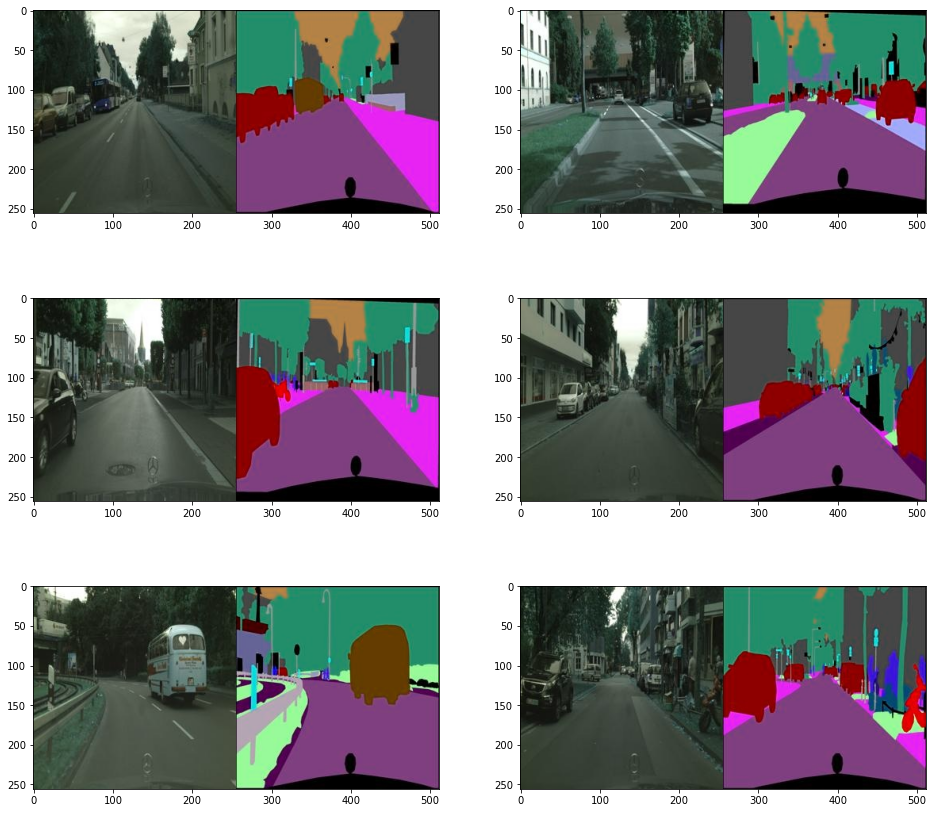

In [2]:
plt.figure(figsize=(16,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3, 2, i)
    plt.imshow(img)

In [3]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


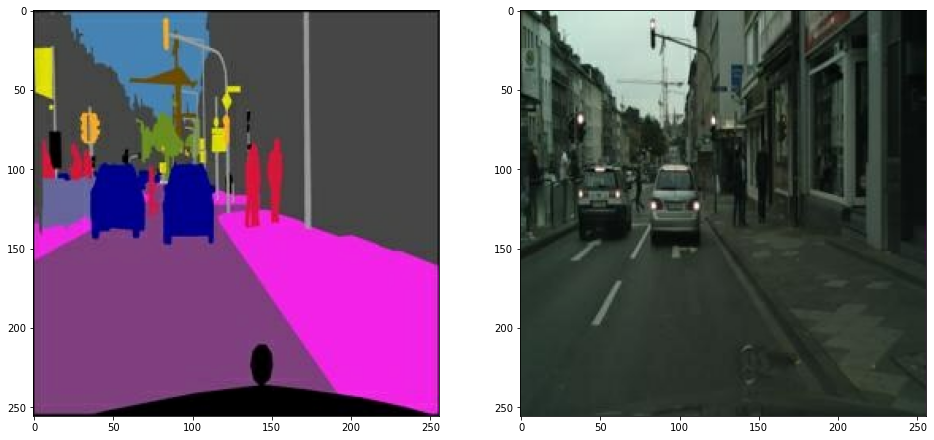

In [4]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x / 127.5) - 1

def denormalize(x):
    x = (x + 1) * 127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, 3)
    # tf.image.decode_image 사용시
    # 'images' contains no shape 에러 발생
    
    w = tf.shape(img)[1] // 2
    segment = img[:, w:, :]
    segment = tf.cast(segment, tf.float32)
    real = img[:, :w, :]
    real = tf.cast(real, tf.float32)
    return normalize(segment), normalize(real)

f = data_path + os.listdir(data_path)[1]
segment, real = load_img(f)

plt.figure(figsize=(16,15))
plt.subplot(121); plt.imshow(denormalize(segment))
plt.subplot(122); plt.imshow(denormalize(real))
plt.show()

### augmentation 적용하기
1. 이미지 크기 조정
2. 무작위로 자르기
3. 무작위로 좌우반전

In [5]:
from tensorflow import image

def resize(segment, real, height, width):
    segment = image.resize(segment, [height, width],
                           method=image.ResizeMethod.NEAREST_NEIGHBOR)
    real = image.resize(real, [height, width],
                        method=image.ResizeMethod.NEAREST_NEIGHBOR)
    return segment, real

def random_crop(segment, real):
    stacked_image = tf.stack([segment, real], axis=0)
    cropped_image = image.random_crop(stacked_image, size=[2, 256, 256, 3])
    return cropped_image[0], cropped_image[1]

@tf.function()
def apply_augmentation(segment, real):
    segment, real = resize(segment, real, 286, 286)
    
    segment, real = random_crop(segment, real)
    
    if tf.random.uniform(()) > 0.5:
        segment = image.flip_left_right(segment)
        real = image.flip_left_right(real)
        
    return segment, real

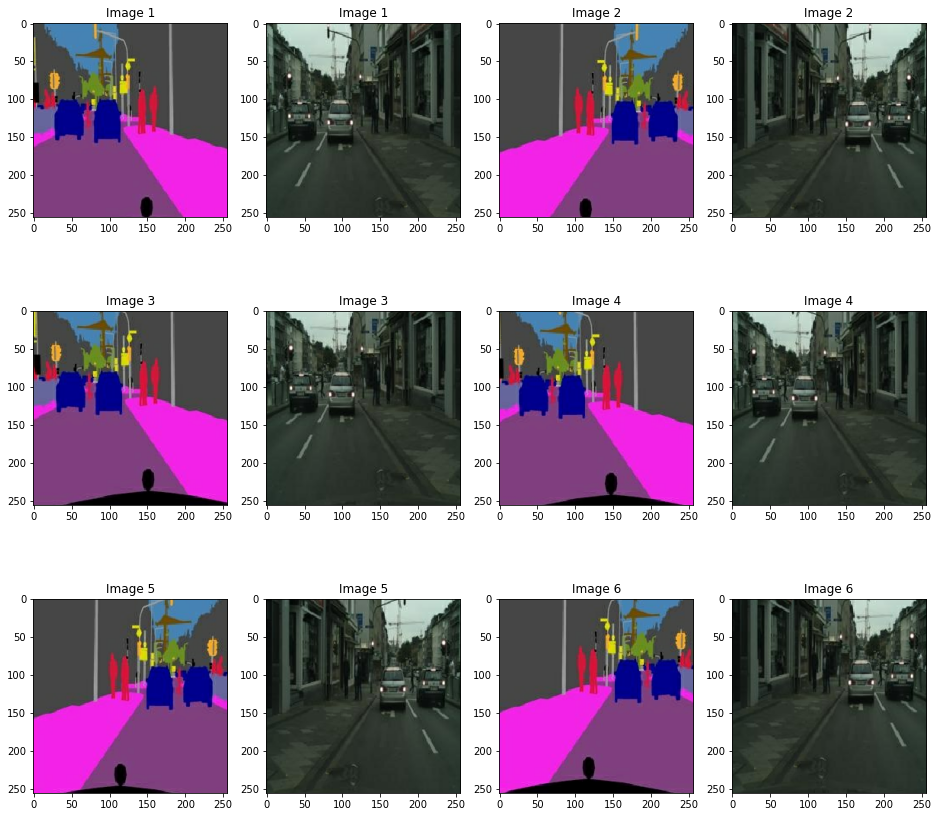

In [6]:
plt.figure(figsize=(16,15))
img_n = 1
for i in range(1, 13, 2):
    aug_segment, aug_real = apply_augmentation(segment, real)
    
    plt.subplot(3, 4, i)
    plt.imshow(denormalize(aug_segment))
    plt.title(f'Image {img_n}')
    plt.subplot(3, 4, i + 1)
    plt.imshow(denormalize(aug_real))
    plt.title(f'Image {img_n}')
    img_n += 1

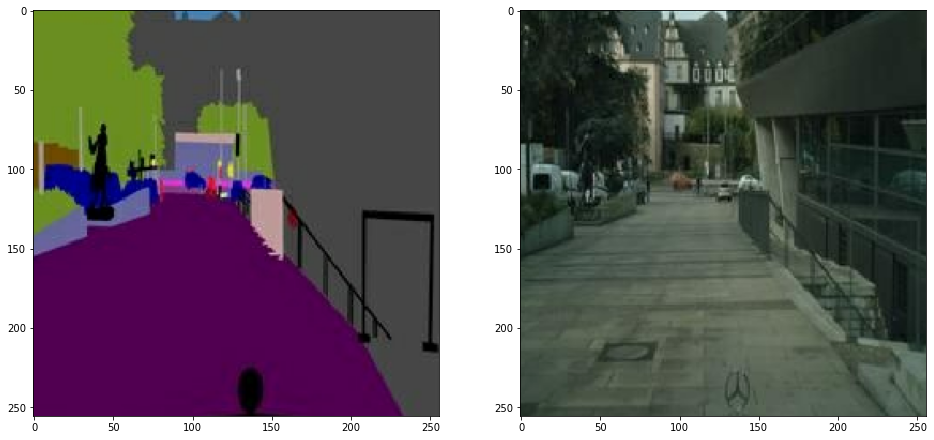

In [7]:
from tensorflow import data

def get_train(img_path):
    segment, real = load_img(img_path)
    segment, real = apply_augmentation(segment, real)
    return segment, real

train_images = data.Dataset.list_files(data_path + '*.jpg')
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
segment, real = (sample[0][0] + 1) * 127.5, (sample[0][1] + 1) * 127.5

plt.figure(figsize=(16,15))
plt.subplot(121); plt.imshow(segment[0].astype(np.uint8))
plt.subplot(122); plt.imshow(real[0].astype(np.uint8))
plt.show()

### Generator 

In [8]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [9]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [10]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

### Discriminator

In [11]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act  # 활성화 함수 여부
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [12]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()


In [13]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

### 손실함수

In [14]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)


In [15]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)


In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gene_opt,
                                 discriminator_optimizer=disc_opt,
                                 generator=UNetGenerator(),
                                 discriminator=Discriminator())

In [17]:
@tf.function
def train_step(segment, real):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_real = generator(segment, training=True)
        # Discriminator 예측
        fake_disc = discriminator(segment, fake_real, training=True)
        real_disc = discriminator(segment, real, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_real, real, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss


In [18]:
EPOCHS = 150

generator = UNetGenerator()
discriminator = Discriminator()

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gene_opt,
                                 discriminator_optimizer=disc_opt,
                                 generator=generator,
                                 discriminator=discriminator)

In [19]:
for epoch in range(1, EPOCHS+1):
    for i, (segment, real) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(segment, real)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 50 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[50]                     
Generator_loss:1.0216                     
L1_loss:0.1856                     
Discriminator_loss:1.3356

EPOCH[1] - STEP[100]                     
Generator_loss:1.9463                     
L1_loss:0.1683                     
Discriminator_loss:0.9732

EPOCH[1] - STEP[150]                     
Generator_loss:2.1916                     
L1_loss:0.1948                     
Discriminator_loss:0.5129

EPOCH[1] - STEP[200]                     
Generator_loss:1.1143                     
L1_loss:0.1681                     
Discriminator_loss:0.7737

EPOCH[1] - STEP[250]                     
Generator_loss:2.1065                     
L1_loss:0.1511                     
Discriminator_loss:1.5341

EPOCH[2] - STEP[50]                     
Generator_loss:2.2502                     
L1_loss:0.2042                     
Discriminator_loss:0.9273

EPOCH[2] - STEP[100]                     
Generator_loss:1.2713                     
L1_loss:0.1642               

EPOCH[12] - STEP[100]                     
Generator_loss:1.2137                     
L1_loss:0.2118                     
Discriminator_loss:0.4908

EPOCH[12] - STEP[150]                     
Generator_loss:0.8689                     
L1_loss:0.2106                     
Discriminator_loss:0.6718

EPOCH[12] - STEP[200]                     
Generator_loss:0.6958                     
L1_loss:0.1528                     
Discriminator_loss:0.9830

EPOCH[12] - STEP[250]                     
Generator_loss:1.3269                     
L1_loss:0.2018                     
Discriminator_loss:0.5760

EPOCH[13] - STEP[50]                     
Generator_loss:1.4497                     
L1_loss:0.2101                     
Discriminator_loss:0.7805

EPOCH[13] - STEP[100]                     
Generator_loss:1.9232                     
L1_loss:0.2216                     
Discriminator_loss:0.2535

EPOCH[13] - STEP[150]                     
Generator_loss:1.0592                     
L1_loss:0.2057       

EPOCH[23] - STEP[150]                     
Generator_loss:1.0031                     
L1_loss:0.1610                     
Discriminator_loss:1.1527

EPOCH[23] - STEP[200]                     
Generator_loss:1.4993                     
L1_loss:0.1899                     
Discriminator_loss:0.5397

EPOCH[23] - STEP[250]                     
Generator_loss:1.4702                     
L1_loss:0.1688                     
Discriminator_loss:1.9111

EPOCH[24] - STEP[50]                     
Generator_loss:0.8871                     
L1_loss:0.2004                     
Discriminator_loss:0.6683

EPOCH[24] - STEP[100]                     
Generator_loss:2.0293                     
L1_loss:0.1984                     
Discriminator_loss:2.1528

EPOCH[24] - STEP[150]                     
Generator_loss:1.9514                     
L1_loss:0.2054                     
Discriminator_loss:1.0856

EPOCH[24] - STEP[200]                     
Generator_loss:1.8452                     
L1_loss:0.2057       

EPOCH[34] - STEP[200]                     
Generator_loss:1.4408                     
L1_loss:0.1825                     
Discriminator_loss:0.8209

EPOCH[34] - STEP[250]                     
Generator_loss:1.0970                     
L1_loss:0.1639                     
Discriminator_loss:1.0582

EPOCH[35] - STEP[50]                     
Generator_loss:1.6361                     
L1_loss:0.1789                     
Discriminator_loss:0.3310

EPOCH[35] - STEP[100]                     
Generator_loss:2.7053                     
L1_loss:0.1641                     
Discriminator_loss:2.5207

EPOCH[35] - STEP[150]                     
Generator_loss:1.1625                     
L1_loss:0.1769                     
Discriminator_loss:0.5412

EPOCH[35] - STEP[200]                     
Generator_loss:1.6274                     
L1_loss:0.1675                     
Discriminator_loss:0.7096

EPOCH[35] - STEP[250]                     
Generator_loss:1.8136                     
L1_loss:0.1469       

EPOCH[45] - STEP[250]                     
Generator_loss:1.0655                     
L1_loss:0.1376                     
Discriminator_loss:1.7496

EPOCH[46] - STEP[50]                     
Generator_loss:0.6648                     
L1_loss:0.1815                     
Discriminator_loss:0.9841

EPOCH[46] - STEP[100]                     
Generator_loss:1.2247                     
L1_loss:0.1645                     
Discriminator_loss:0.8694

EPOCH[46] - STEP[150]                     
Generator_loss:1.1173                     
L1_loss:0.1572                     
Discriminator_loss:1.0936

EPOCH[46] - STEP[200]                     
Generator_loss:2.2857                     
L1_loss:0.1630                     
Discriminator_loss:2.4144

EPOCH[46] - STEP[250]                     
Generator_loss:1.1785                     
L1_loss:0.1324                     
Discriminator_loss:1.4254

EPOCH[47] - STEP[50]                     
Generator_loss:0.7653                     
L1_loss:0.1843        

EPOCH[57] - STEP[50]                     
Generator_loss:1.5067                     
L1_loss:0.1609                     
Discriminator_loss:0.9089

EPOCH[57] - STEP[100]                     
Generator_loss:0.5063                     
L1_loss:0.1796                     
Discriminator_loss:1.4457

EPOCH[57] - STEP[150]                     
Generator_loss:1.7502                     
L1_loss:0.1482                     
Discriminator_loss:1.1229

EPOCH[57] - STEP[200]                     
Generator_loss:1.5270                     
L1_loss:0.1695                     
Discriminator_loss:1.6931

EPOCH[57] - STEP[250]                     
Generator_loss:0.7494                     
L1_loss:0.1443                     
Discriminator_loss:1.8942

EPOCH[58] - STEP[50]                     
Generator_loss:1.4496                     
L1_loss:0.1731                     
Discriminator_loss:0.7436

EPOCH[58] - STEP[100]                     
Generator_loss:2.3144                     
L1_loss:0.1664        

EPOCH[68] - STEP[100]                     
Generator_loss:3.0729                     
L1_loss:0.1856                     
Discriminator_loss:1.3181

EPOCH[68] - STEP[150]                     
Generator_loss:1.5501                     
L1_loss:0.1598                     
Discriminator_loss:1.5297

EPOCH[68] - STEP[200]                     
Generator_loss:1.9704                     
L1_loss:0.1384                     
Discriminator_loss:0.3959

EPOCH[68] - STEP[250]                     
Generator_loss:1.8672                     
L1_loss:0.1458                     
Discriminator_loss:1.6145

EPOCH[69] - STEP[50]                     
Generator_loss:1.8322                     
L1_loss:0.1494                     
Discriminator_loss:0.7824

EPOCH[69] - STEP[100]                     
Generator_loss:2.0247                     
L1_loss:0.1539                     
Discriminator_loss:1.0052

EPOCH[69] - STEP[150]                     
Generator_loss:2.3980                     
L1_loss:0.1534       

EPOCH[79] - STEP[150]                     
Generator_loss:1.6041                     
L1_loss:0.1613                     
Discriminator_loss:2.5223

EPOCH[79] - STEP[200]                     
Generator_loss:2.5909                     
L1_loss:0.1569                     
Discriminator_loss:1.2241

EPOCH[79] - STEP[250]                     
Generator_loss:1.9352                     
L1_loss:0.1665                     
Discriminator_loss:1.1576

EPOCH[80] - STEP[50]                     
Generator_loss:0.8116                     
L1_loss:0.1329                     
Discriminator_loss:1.4801

EPOCH[80] - STEP[100]                     
Generator_loss:0.9289                     
L1_loss:0.1411                     
Discriminator_loss:1.0676

EPOCH[80] - STEP[150]                     
Generator_loss:2.2588                     
L1_loss:0.1628                     
Discriminator_loss:0.9372

EPOCH[80] - STEP[200]                     
Generator_loss:0.6610                     
L1_loss:0.1584       

EPOCH[90] - STEP[200]                     
Generator_loss:1.7260                     
L1_loss:0.1523                     
Discriminator_loss:1.2157

EPOCH[90] - STEP[250]                     
Generator_loss:0.5388                     
L1_loss:0.1530                     
Discriminator_loss:1.1765

EPOCH[91] - STEP[50]                     
Generator_loss:0.6487                     
L1_loss:0.1433                     
Discriminator_loss:1.0740

EPOCH[91] - STEP[100]                     
Generator_loss:2.5572                     
L1_loss:0.1438                     
Discriminator_loss:1.0035

EPOCH[91] - STEP[150]                     
Generator_loss:1.8103                     
L1_loss:0.1700                     
Discriminator_loss:0.4976

EPOCH[91] - STEP[200]                     
Generator_loss:0.9019                     
L1_loss:0.1440                     
Discriminator_loss:0.7546

EPOCH[91] - STEP[250]                     
Generator_loss:1.6599                     
L1_loss:0.1511       

EPOCH[101] - STEP[250]                     
Generator_loss:1.7410                     
L1_loss:0.1365                     
Discriminator_loss:0.9218

EPOCH[102] - STEP[50]                     
Generator_loss:1.3885                     
L1_loss:0.1668                     
Discriminator_loss:0.4236

EPOCH[102] - STEP[100]                     
Generator_loss:0.7445                     
L1_loss:0.1647                     
Discriminator_loss:0.8596

EPOCH[102] - STEP[150]                     
Generator_loss:1.3821                     
L1_loss:0.1322                     
Discriminator_loss:1.1121

EPOCH[102] - STEP[200]                     
Generator_loss:1.0665                     
L1_loss:0.1835                     
Discriminator_loss:0.6763

EPOCH[102] - STEP[250]                     
Generator_loss:1.3431                     
L1_loss:0.1501                     
Discriminator_loss:0.6999

EPOCH[103] - STEP[50]                     
Generator_loss:1.0606                     
L1_loss:0.1345 

EPOCH[112] - STEP[250]                     
Generator_loss:0.8179                     
L1_loss:0.1453                     
Discriminator_loss:1.2770

EPOCH[113] - STEP[50]                     
Generator_loss:2.4847                     
L1_loss:0.1330                     
Discriminator_loss:1.8415

EPOCH[113] - STEP[100]                     
Generator_loss:0.5087                     
L1_loss:0.1339                     
Discriminator_loss:1.2783

EPOCH[113] - STEP[150]                     
Generator_loss:1.2914                     
L1_loss:0.1319                     
Discriminator_loss:1.2051

EPOCH[113] - STEP[200]                     
Generator_loss:0.4592                     
L1_loss:0.1441                     
Discriminator_loss:1.3449

EPOCH[113] - STEP[250]                     
Generator_loss:1.1191                     
L1_loss:0.1374                     
Discriminator_loss:0.7590

EPOCH[114] - STEP[50]                     
Generator_loss:1.3186                     
L1_loss:0.1395 

EPOCH[123] - STEP[250]                     
Generator_loss:1.1710                     
L1_loss:0.1560                     
Discriminator_loss:0.6577

EPOCH[124] - STEP[50]                     
Generator_loss:1.9927                     
L1_loss:0.1331                     
Discriminator_loss:0.9020

EPOCH[124] - STEP[100]                     
Generator_loss:1.6253                     
L1_loss:0.1680                     
Discriminator_loss:0.4383

EPOCH[124] - STEP[150]                     
Generator_loss:1.6565                     
L1_loss:0.1503                     
Discriminator_loss:0.7852

EPOCH[124] - STEP[200]                     
Generator_loss:0.8385                     
L1_loss:0.1465                     
Discriminator_loss:0.8713

EPOCH[124] - STEP[250]                     
Generator_loss:0.8685                     
L1_loss:0.1709                     
Discriminator_loss:0.7583

EPOCH[125] - STEP[50]                     
Generator_loss:0.6861                     
L1_loss:0.1298 

EPOCH[134] - STEP[250]                     
Generator_loss:0.8687                     
L1_loss:0.1426                     
Discriminator_loss:1.0105

EPOCH[135] - STEP[50]                     
Generator_loss:1.4463                     
L1_loss:0.1232                     
Discriminator_loss:1.2023

EPOCH[135] - STEP[100]                     
Generator_loss:1.5599                     
L1_loss:0.1273                     
Discriminator_loss:0.5842

EPOCH[135] - STEP[150]                     
Generator_loss:0.8621                     
L1_loss:0.1237                     
Discriminator_loss:1.1437

EPOCH[135] - STEP[200]                     
Generator_loss:1.3306                     
L1_loss:0.1359                     
Discriminator_loss:0.7006

EPOCH[135] - STEP[250]                     
Generator_loss:2.0375                     
L1_loss:0.1234                     
Discriminator_loss:1.6654

EPOCH[136] - STEP[50]                     
Generator_loss:0.9398                     
L1_loss:0.1328 

EPOCH[145] - STEP[250]                     
Generator_loss:2.3336                     
L1_loss:0.1239                     
Discriminator_loss:1.2950

EPOCH[146] - STEP[50]                     
Generator_loss:1.1892                     
L1_loss:0.1598                     
Discriminator_loss:0.6864

EPOCH[146] - STEP[100]                     
Generator_loss:1.0518                     
L1_loss:0.1342                     
Discriminator_loss:0.8833

EPOCH[146] - STEP[150]                     
Generator_loss:0.8679                     
L1_loss:0.1462                     
Discriminator_loss:0.7358

EPOCH[146] - STEP[200]                     
Generator_loss:2.3949                     
L1_loss:0.1330                     
Discriminator_loss:1.0618

EPOCH[146] - STEP[250]                     
Generator_loss:1.1972                     
L1_loss:0.1446                     
Discriminator_loss:0.6980

EPOCH[147] - STEP[50]                     
Generator_loss:1.4150                     
L1_loss:0.1330 

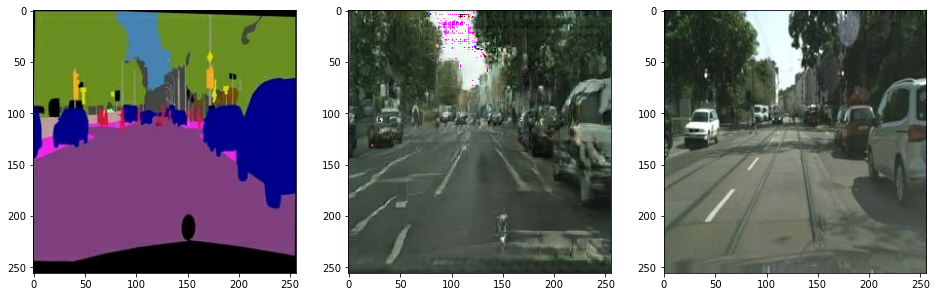

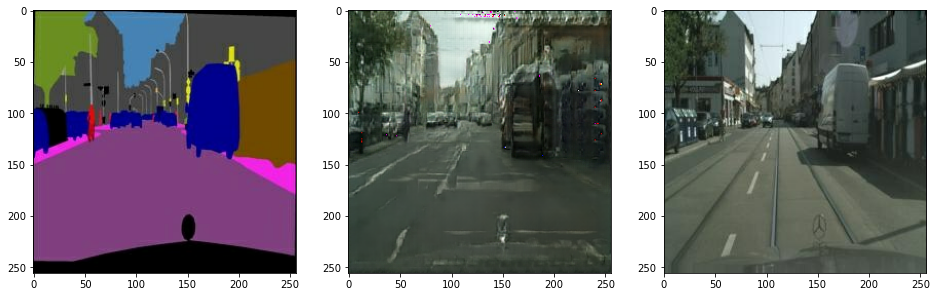

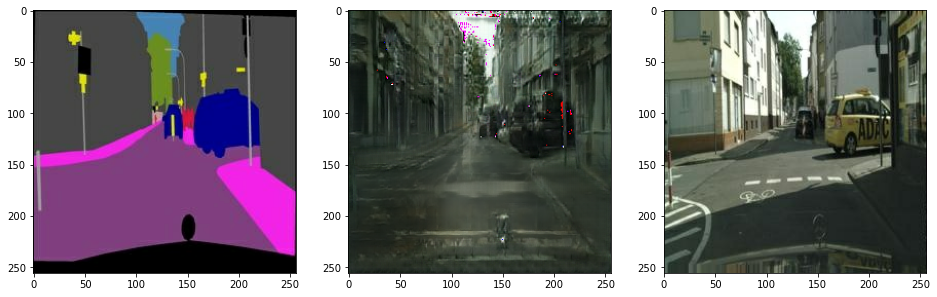

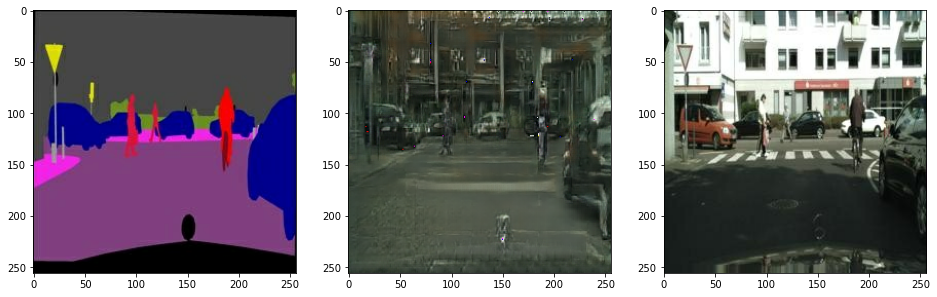

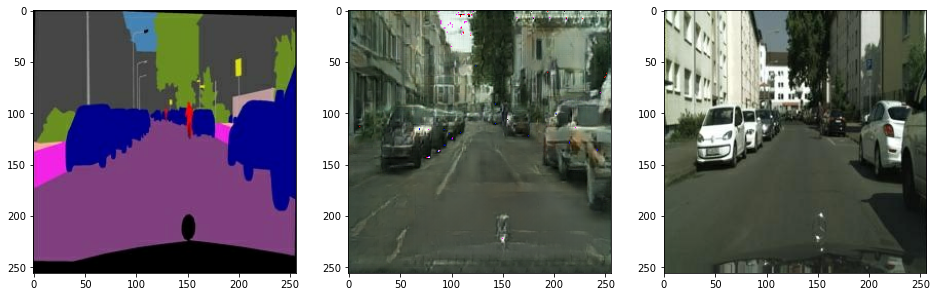

In [20]:
val_path = os.getenv('HOME') + '/aiffel/conditional_generation/cityscapes/val/'

for i in range(5):
    f = val_path + os.listdir(val_path)[i]
    segment, real = load_img(f)
    
    pred = generator(tf.expand_dims(segment,0))
    pred = denormalize(pred)
    
    plt.figure(figsize=(16,15))
    plt.subplot(131); plt.imshow(denormalize(segment))
    plt.subplot(132); plt.imshow(pred[0])
    plt.subplot(133); plt.imshow(denormalize(real))
    